# Section Structure & Written Expression

Epoch 1/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - accuracy: 0.6403 - loss: 0.6707 - val_accuracy: 0.9438 - val_loss: 0.4909 - learning_rate: 0.0010
Epoch 2/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9512 - loss: 0.2107 - val_accuracy: 0.9438 - val_loss: 0.4399 - learning_rate: 0.0010
Epoch 3/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9491 - loss: 0.1939 - val_accuracy: 0.9438 - val_loss: 0.4451 - learning_rate: 0.0010
Epoch 4/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9543 - loss: 0.1819 - val_accuracy: 0.9438 - val_loss: 0.4526 - learning_rate: 0.0010
Epoch 5/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9500 - loss: 0.1769 - val_accuracy: 0.9469 - val_loss: 0.4434 - learning_rate: 0.0010
Epoch 6/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9511 - loss: 0.1685 - val_accuracy: 0.9438 - val_loss: 0.4173 - learning_rate: 0.0010
Epoch 7/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9516 - loss: 0.1644 - val_ac

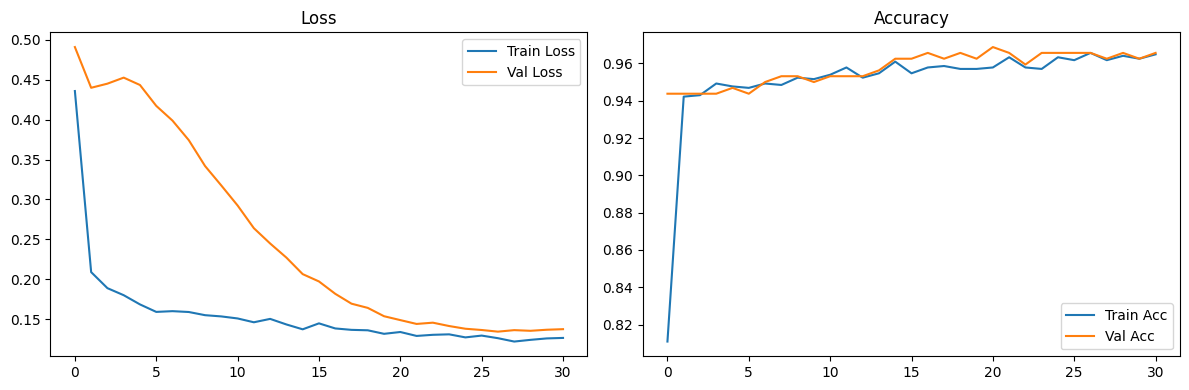

In [ ]:
import json
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
from tensorflow.keras import regularizers

# Set seed
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

# Load data dari JSON (sudah dalam bentuk list of dict)
with open('data/writting.json', 'r') as f:
    raw_questions = json.load(f)

# Ambil pertanyaan Structure dan Written Expression
questions = [
    {
        'part': q['part'],
        'question': q['question'],
        'options': [
            q['options'].get('A', ''),
            q['options'].get('B', ''),
            q['options'].get('C', ''),
            q['options'].get('D', '')
        ],
        'answer': q['answer']
    }
    for q in raw_questions
    if q['part'] in ['Structure', 'Written Expression']
]

# Pisahkan soal per part
structure_qs = [q for q in questions if q['part'] == 'Structure']
written_qs = [q for q in questions if q['part'] == 'Written Expression']

# Simulasi data
data = []
target_labels = ['Structure', 'Written Expression']
max_per_class = 1000
target_counts = {lbl: 0 for lbl in target_labels}
n_sample_per_user = 50

while not all(c >= max_per_class for c in target_counts.values()):
    base_error = np.random.uniform(0.25, 0.35)
    bias_error = np.random.uniform(0.1, 0.15)
    simulated_label = np.random.choice(target_labels)
    error_probs = {lbl: base_error for lbl in target_labels}
    error_probs[simulated_label] += bias_error

    mandatory = []
    if structure_qs:
        mandatory.append(np.random.choice(structure_qs))
    if written_qs:
        mandatory.append(np.random.choice(written_qs))
    rest = np.random.choice(questions, size=n_sample_per_user - len(mandatory), replace=False)
    sampled = np.array(mandatory + list(rest))

    # Hitung benar/salah
    user_results = [
        (q['part'], np.random.rand() > error_probs[q['part']])
        for q in sampled
    ]

    # Hitung error rate per part
    stats = {}
    for part in target_labels:
        part_res = [r for r in user_results if r[0] == part]
        if len(part_res) == 0:
            stats[f"{part}_err"] = 0.0
        else:
            wrong = sum(not r[1] for r in part_res)
            stats[f"{part}_err"] = wrong / len(part_res)

    weak_part = max(stats, key=stats.get).replace('_err', '')
    if np.random.rand() < 0.05:
        weak_part = np.random.choice(target_labels)
    if target_counts[weak_part] >= max_per_class:
        continue

    data.append({
        'structure_err': stats['Structure_err'],
        'written_err': stats['Written Expression_err'],
        'structure_vs_written': stats['Structure_err'] - stats['Written Expression_err'],
        'weak_part': weak_part
    })
    target_counts[weak_part] += 1

# Buat DataFrame
df = pd.DataFrame(data)
df['structure_vs_written'] += np.random.normal(0, 0.03, size=len(df))

# Fitur
features = ['structure_err', 'written_err', 'structure_vs_written']
X = df[features].values
X = StandardScaler().fit_transform(X)

le = LabelEncoder()
y_int = le.fit_transform(df['weak_part'])
y = tf.keras.utils.to_categorical(y_int, num_classes=2)

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y_int, random_state=SEED
)

# Model
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(3,)),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(2, activation='softmax')
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Callbacks
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    min_delta=0.005,
    patience=10,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=1e-5,
    verbose=1
)

# Training
history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=100,
    batch_size=64,
    callbacks=[early_stop, reduce_lr],
    verbose=1
)

# Evaluasi
loss, acc = model.evaluate(X_test, y_test, verbose=0)
print(f"\n🎯 Test Accuracy: {acc:.2f}")

# Classification report
y_pred = model.predict(X_test).argmax(axis=1)
y_true = y_test.argmax(axis=1)
print(classification_report(y_true, y_pred, target_names=le.classes_))

# Plot loss & accuracy
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title("Loss"); plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title("Accuracy"); plt.legend()
plt.tight_layout()
plt.show()


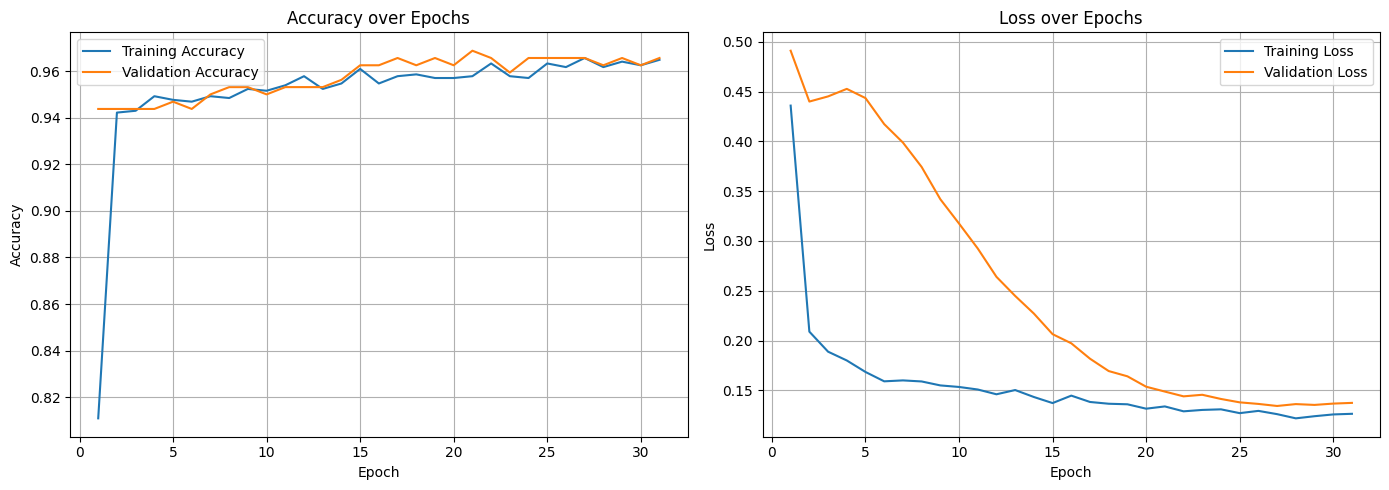

In [3]:
import matplotlib.pyplot as plt

# Visualisasi hasil evaluasi model
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(1, len(acc) + 1)

plt.figure(figsize=(14, 5))

# Plot akurasi
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy over Epochs')
plt.legend()
plt.grid(True)

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


In [ ]:
# 12. Simpan model dan label encoder
model.save('model/writting_classifier.h5')
import joblib
joblib.dump(le, 'model/writting_encoder.pkl')



['written_label_encoder.pkl']

In [ ]:
import numpy as np
import tensorflow as tf
import joblib

# Load model dan label encoder
model = tf.keras.models.load_model('model/writting_classifier.h5')
le = joblib.load('model/writting_encoder.pkl')

# Contoh error rate user
short, ext, talk = 0.1, 0.1, 0.8
structure_vs_written = short - talk  # karena short = structure_err, talk = written_err

# Pastikan urutan fitur sama seperti saat training
features = np.array([[short, talk, structure_vs_written]])

# # Skala fitur (gunakan StandardScaler yang sudah dilatih jika Anda menyimpannya)
# scaler = joblib.load('written_scaler.pkl')  # jika Anda menyimpannya
# features = scaler.transform(features)

# Prediksi
pred = model.predict(features)
pred_probs = pred[0]
label_index = np.argmax(pred_probs)
pred_label = le.inverse_transform([label_index])[0]

# Output
print(f"\n✅ Prediksi kelemahan user: {pred_label}")
print(f"📊 Probabilitas prediksi: {pred_probs}")
print(f"🏷️ Label indeks: {label_index}, Label kelas: {le.classes_[label_index]}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 683ms/step

✅ Prediksi kelemahan user: Written Expression
📊 Probabilitas prediksi: [0.02903848 0.97096145]
🏷️ Label indeks: 1, Label kelas: Written Expression
